In [1]:
import matplotlib.pyplot as plt

In [2]:
#with open("/home/stes/cebra-behavior.json", "w") as fh:
#  for line in single.T.to_dict().values():
#    fh.write(json.dumps(line) + "\n")

In [3]:
#len(single_errors), len(multi_errors)

In [4]:
#with open("/home/stes/ssh/cebra_public/results/figure_4/hippocampus_hiddendims/multisession.lst", "r") as fh:
#  files = list(filter(len, fh.read().split("\n")))
#  
#print(len(files))
#
#with open("/home/stes/ssh/cebra_public/results/figure_4/hippocampus_hiddendims/multisession.err", "w") as fh:
#  fh.write("\n".join([
#    files[err] for err in multi_errors
#  ]))

In [2]:
def figure():
    plt.figure(figsize=(2, 2), dpi=200)

In [3]:
def mean(v):
  return sum(v) / len(v)

def sort_results(metrics, results):

  full_metrics = metrics + ["data_mode"]

  sorted_results = results.copy()
  sorted_results['seed'] = -1
  idx = sorted_results.pivot_table(
    "logdir",
    index = full_metrics,
    aggfunc = "count"
  )
  sorted_results = sorted_results.set_index(full_metrics) 
  for i in idx.T:
    sorted_results.loc[i, "seed"] = np.arange(10)

  sorted_results.groupby(full_metrics)["seed"].apply(tuple).apply(lambda v : v == tuple(range(10))).all().all()
  return sorted_results.reset_index()

sorted_results = sort_results(metrics, results)

NameError: name 'metrics' is not defined

In [127]:
aggregated_metrics = [m for m in full_metrics if m not in ["repeat", "seed"]]
aggregated_results = sorted_results.groupby(aggregated_metrics).agg(mean).reset_index()
aggregated_results.columns

/tmp/ipykernel_171360/408837273.py:5: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  aggregated_results = sorted_results.groupby(aggregated_metrics).agg(mean).reset_index()


Index(['batch_size', 'conditional', 'delta', 'device', 'learning_rate',
       'loss_distance', 'model', 'num_hidden_units', 'num_output', 'num_steps',
       'save_emissions', 'save_frequency', 'share_model', 'temperature',
       'time_offset', 'tqdm', 'train_ratio', 'valid_frequency', 'valid_ratio',
       'variant', 'steps', 'data_mode', 'valid_total_r2',
       'valid_position_error', 'test_total_r2', 'test_position_error',
       'train_consistency_raw', 'train_consistency', 'valid_consistency_raw',
       'valid_consistency', 'test_consistency_raw', 'test_consistency',
       'valid_total_r2_raw', 'test_total_r2_raw', 'valid_position_error_raw',
       'test_position_error_raw', 'seed'],
      dtype='object')

In [128]:
idx = aggregated_results[aggregated_results.data_mode == "single-session"].sort_values("train_consistency").groupby("data_mode").tail(1).set_index(aggregated_metrics).index
sorted_results.set_index(aggregated_metrics).loc[idx].reset_index().groupby(aggregated_metrics + ["seed"]).mean().reset_index().to_csv("cebra-behavior.csv")

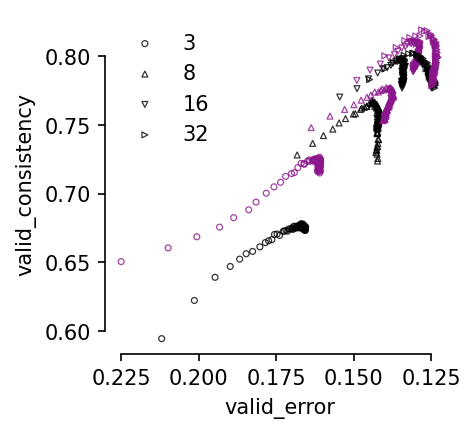

In [129]:
def tradeoff_plot(data, key, condition):
  styles = '1o', '2^', '3v', '4>', '5s'
  plt.figure(figsize = (3, 3), dpi = 150)

  for (color, marker), dim in zip(styles, condition):
    filtered_data = data[(data[key] == dim) & (data.data_mode == "single-session")]

    plt.scatter(
      filtered_data.valid_position_error,
      filtered_data.valid_consistency,
      facecolor = 'none',
      edgecolor = f'black',
      alpha = .8,
      linewidth = .6,
      s = 8,
      marker = marker,
      label = dim
    )

    filtered_data = data[(data[key] == dim) & (data.data_mode == "multi-session")]

    plt.scatter(
      filtered_data.valid_position_error,
      filtered_data.valid_consistency,
      facecolor = 'none',
      edgecolor = f'#8B168B',
      alpha = .8,
      linewidth = .6,
      s = 8,
      marker = marker,
    )

  plt.legend(frameon = False)
  plt.gca().invert_xaxis()
  sns.despine(trim = True)
  plt.xlabel("valid_error")
  plt.ylabel("valid_consistency")
  plt.show()

data = aggregated_results[aggregated_results.steps > 500].sort_values("valid_position_error")
#tradeoff_plot(data, key = 'num_output', condition = [3, 8, 16, 32])
tradeoff_plot(data, key = 'num_hidden_units', condition = [3, 8, 16, 32])

In [130]:
def compute(sorted_results):
  sorted_results = sorted_results.copy()
  sorted_results["mean_train_consistency"] = sorted_results["train_consistency_raw"].apply(np.mean)

  groupby = [m for m in metrics if m != "repeat"] + ["data_mode"]
  sorted_results

  #.groupby(groupby).mean().sort_values("mean_train_consistency") #.tail(1)

  #.apply(np.mean) #.explode("test_position_error_raw")

  sorted_results = sorted_results[
    (sorted_results.num_hidden_units == 32) & 
    (sorted_results.steps == 5000)
  ].explode("test_position_error_raw")

  sorted_results["animal"] = np.arange(len(sorted_results)) % 4
  return sorted_results

result = compute(sorted_results).pivot_table(
  "test_position_error_raw",
  index = ("data_mode", "animal"),
  columns = "seed",
  aggfunc = "mean"
).agg(list, axis = 1).unstack().T

#result.to_pickle("figure4_decoding_results.pkl")

#.sort_values("mean_train_run_consistency"
#).groupby(["data_mode", "seed", "repeat", "num_output"]
#).tail(1)

# 10 seeds x 3 repeats

250     20
2750    20
4500    20
4250    20
4000    20
3750    20
3500    20
3250    20
3000    20
2500    20
500     20
2250    20
2000    20
1750    20
1500    20
1250    20
1000    20
750     20
4750    20
Name: steps, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


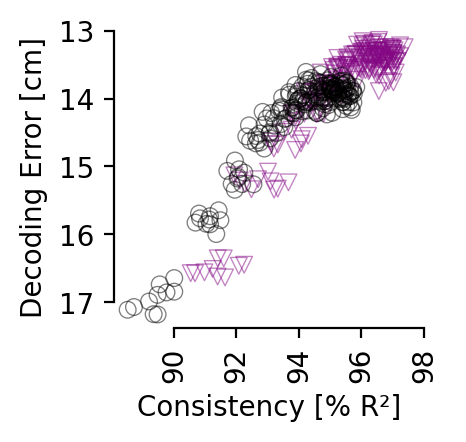

In [144]:
from matplotlib.markers import MarkerStyle

"""
  baseline = sorted_results[
    (sorted_results.num_hidden_units == 32) & 
    (sorted_results.steps == 0)
  ].sort_values("valid_position_error"
  ).groupby(["data_mode", "seed", "repeat", "num_output"]
  ).head(1)
"""

def plot(sorted_results, metric, yaxis):

  filtered_results = sorted_results[
    (sorted_results.num_hidden_units == 32) &
    (sorted_results.num_output == 32) &
    (sorted_results.steps > 100) &
    (sorted_results.steps < 5000)
  ].set_index("data_mode").sort_values("valid_position_error").groupby(["steps", "data_mode", "seed", "repeat", "num_output"]).head(1)
  filtered_results = filtered_results[filtered_results.steps % 250 == 0]
  filtered_results["train_consistency"] *= 100
  filtered_results["test_position_error"] *= 100
  #baseline['data_mode'] = "baseline"
  #baseline = baseline.set_index("data_mode").copy()
  #filtered_results = pd.concat([filtered_results, baseline]).sort_values("valid_position_error", ascending = False)

  #fig = sns.catplot(
  #    data=filtered_results.reset_index(), kind="swarm",
  #    hue="data_mode", y=metric, x="data_mode",
  #    palette="dark", alpha=.6, height=6,
  #    legend = False
  #)
  
  #display(filtered_results)
  
  filtered_results = filtered_results.groupby(["steps", "data_mode", "seed"]).mean()
  display(filtered_results.reset_index().steps.value_counts())
  
  plt.figure(figsize = (2, 2), dpi = 200)
  sns.scatterplot(
    data = filtered_results.reset_index().sort_values("data_mode"),
    x = 'train_consistency',
    y = 'test_position_error',
    style = 'data_mode',
    hue = 'data_mode',
    palette = ['#840884', 'k'],
    markers=[MarkerStyle('v', 'none'), MarkerStyle('o', 'none')],
    alpha = .5,
    ci = None,
    legend = False
  )

  plt.legend(loc = (1,0), frameon = False)
  plt.xlabel("Consistency [% R²]")

  #fig.figure.set_size_inches(2, 2)
  #fig.figure.set_dpi(200)

  #plt.xlim([.95, 1.0])
  plt.xticks([90, 92, 94, 96, 98])
  #plt.gca().spines["bottom"].set_bounds([.96, 1.0])
  sns.despine(trim = True)
  plt.ylabel(yaxis)
  plt.xlabel("Consistency [% R²]")
  #plt.gca().set_xticklabels(["random", "single", "multi"])
  plt.xticks(rotation=90)
  plt.gca().invert_yaxis()
  plt.show()
  
  
plot(sorted_results, metric = "test_position_error", yaxis = "Decoding Error [cm]")
#plot(sorted_results, metric = "train_consistency", yaxis = "Consistency [R², train]")
#plot(sorted_results, metric = "test_consistency", yaxis = "Consistency [R², test]")

data_mode
multi-session     0.139947
single-session    0.139954
Name: valid_position_error, dtype: float64

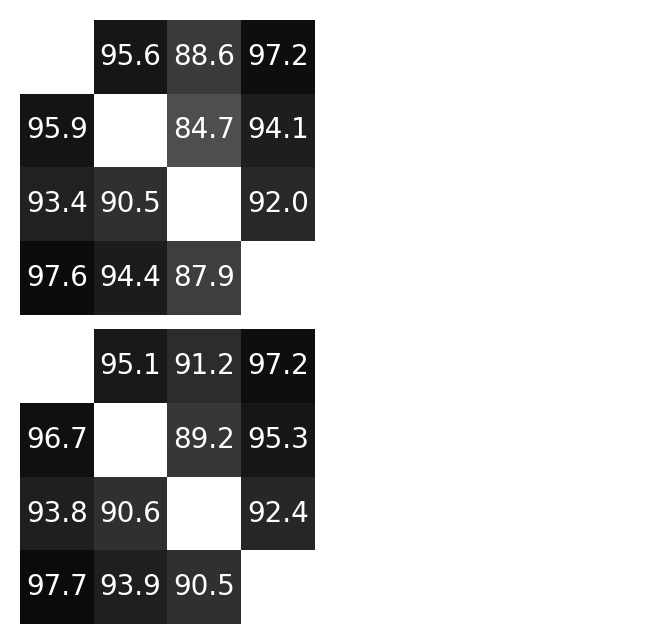

In [142]:
def show_sweep(df):
  for c in df.columns:
    try:
      values = df[c].unique()
    except TypeError:
      continue
    #if len(values) != len(df):
    if len(values) > 1:
      print(c, values)
      
filtered_results = aggregated_results[
  (aggregated_results.batch_size == 512) & 
  (aggregated_results.learning_rate == 0.0003) & 
  (aggregated_results.num_output == 32) &
  (aggregated_results.num_hidden_units == 32)
].set_index("data_mode")

filtered_results = filtered_results[filtered_results["valid_position_error"] < .14]
display(filtered_results.sort_values("valid_position_error")["valid_position_error"].groupby("data_mode").tail(1))
filtered_results = filtered_results.sort_values("valid_position_error").groupby("data_mode").tail(1)

_, axes = plt.subplots(2,2,figsize=(4, 4), dpi = 200)

for ax_row, data_mode in zip(axes, ["single-session", "multi-session"]):
  
  for ax, split in zip(ax_row, ["train"]):
  
    values = filtered_results[f"{split}_consistency_raw"].loc[data_mode]

    cfm = np.zeros((4,4))
    cfm[:] = float("nan")
    cfm[~np.eye(4).astype(bool)] = values
    sns.heatmap(
      cfm * 100, 
      cmap = 'gray_r', 
      vmin = 50, 
      vmax = 100, 
      annot = True, 
      fmt = '.1f', 
      square = True, 
      cbar = False,
      ax = ax
    )
    
for ax in axes.flatten():
  ax.axis("off")
    
plt.subplots_adjust(wspace=-0.005, hspace=0.05)
plt.show()

In [141]:
filtered_results[f"train_consistency_raw"].loc["multi-session"], \
filtered_results[f"train_consistency_raw"].loc["single-session"]

(array([0.95081546, 0.91219784, 0.97159572, 0.9668054 , 0.89214698,
        0.95330396, 0.93798715, 0.90619733, 0.92378746, 0.97700708,
        0.93911369, 0.90545486]),
 array([0.95555933, 0.88572262, 0.97200465, 0.9593825 , 0.84737061,
        0.94094321, 0.93445153, 0.90453392, 0.92011637, 0.97647199,
        0.94380083, 0.87852935]))

In [139]:
import scipy.stats

scipy.stats.ttest_rel(
  np.array([0.95081546, 0.91219784, 0.97159572, 0.9668054 , 0.89214698,
        0.95330396, 0.93798715, 0.90619733, 0.92378746, 0.97700708,
        0.93911369, 0.90545486]),
  np.array([0.95555933, 0.88572262, 0.97200465, 0.9593825 , 0.84737061,
        0.94094321, 0.93445153, 0.90453392, 0.92011637, 0.97647199,
        0.94380083, 0.87852935]),
  alternative="greater"
)

Ttest_relResult(statistic=2.2233272319685495, pvalue=0.024042329925369157)

In [34]:
aggregated_results[
  (aggregated_results.batch_size == 512) & 
  (aggregated_results.learning_rate == 0.0003) & 
  (aggregated_results.num_output == 32) &
  (aggregated_results.num_hidden_units == 32)
].set_index("data_mode")

,batch_size,conditional,delta,device,learning_rate,loss_distance,model,num_hidden_units,num_output,num_steps,...,train_consistency,valid_consistency_raw,valid_consistency,test_consistency_raw,test_consistency,valid_total_r2_raw,test_total_r2_raw,valid_position_error_raw,test_position_error_raw,seed
data_mode,,,,,,,,,,,,,,,,,,,,,
multi-session,512,time_delta,0.1,cuda,0.0003,cosine,offset10-model,32,32,20000,...,0.641216,"[0.3856005381150333, 0.4554856290590775, 0.488...",0.443215,"[0.45607678062863505, 0.48407477513016517, 0.5...",0.487318,"[0.22072505816280666, -0.04760153005082106, -0...","[0.25999863613800633, -0.020463520775653016, -...","[0.26187110096216204, 0.22260556717713673, 0.4...","[0.23601582099994023, 0.23281885584195455, 0.4...",4.5
single-session,512,time_delta,0.1,cuda,0.0003,cosine,offset10-model,32,32,20000,...,0.647141,"[0.38184962228138347, 0.45479972401876867, 0.4...",0.444731,"[0.4653878362536158, 0.48532731472503193, 0.53...",0.495101,"[0.24477737327175053, -0.05101330835700776, -0...","[0.2841075934386833, -0.008331047167074217, -0...","[0.25395283053318657, 0.2245609651009242, 0.46...","[0.22806160002946854, 0.23351751367251078, 0.4...",4.5
multi-session,512,time_delta,0.1,cuda,0.0003,cosine,offset10-model,32,32,20000,...,0.921919,"[0.7712751331612371, 0.7434054772575379, 0.855...",0.790032,"[0.8043163376693544, 0.7323931537270926, 0.854...",0.797020,"[0.722302470280333, 0.24764361223686523, -0.18...","[0.7181657795620315, 0.20649772067392425, -0.2...","[0.07449647262692452, 0.13256745090087255, 0.2...","[0.06417356270054976, 0.14439831376075746, 0.2...",4.5
single-session,512,time_delta,0.1,cuda,0.0003,cosine,offset10-model,32,32,20000,...,0.906139,"[0.757853838975713, 0.7021100100375757, 0.8510...",0.770337,"[0.8015895978790623, 0.7052658701384648, 0.847...",0.784887,"[0.7051085406347045, 0.24144143550302433, -0.1...","[0.7088096032918059, 0.2364481897060962, -0.22...","[0.07935510774453482, 0.13632262473305065, 0.2...","[0.06910601891577244, 0.1443520113825798, 0.30...",4.5
multi-session,512,time_delta,0.1,cuda,0.0003,cosine,offset10-model,32,32,20000,...,0.936527,"[0.7993546581741533, 0.7626776077731735, 0.871...",0.811215,"[0.8266689286623451, 0.7588279810208685, 0.876...",0.820669,"[0.7254488411182067, 0.3359903375652672, -0.14...","[0.7202513206828577, 0.26707192701953064, -0.2...","[0.07195912239452203, 0.12611960644523304, 0.2...","[0.0614293958991766, 0.13478074421485264, 0.27...",4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
single-session,512,time_delta,0.1,cuda,0.0003,cosine,offset10-model,32,32,20000,...,0.986568,"[0.7346223817915668, 0.8082773366219217, 0.876...",0.806365,"[0.8124197524542385, 0.8085199180035486, 0.862...",0.827774,"[0.7283436138774118, 0.23282107647905212, -0.1...","[0.7198224496146552, 0.2503537913314571, -0.24...","[0.06419123113155364, 0.13670286337534587, 0.1...","[0.059031869967778525, 0.14432805602749188, 0....",4.5
multi-session,512,time_delta,0.1,cuda,0.0003,cosine,offset10-model,32,32,20000,...,0.990839,"[0.7500531888123262, 0.7931739760573127, 0.869...",0.804237,"[0.8262795024208821, 0.7887917736987967, 0.860...",0.825219,"[0.7337484647750468, 0.24053185179776077, -0.1...","[0.7128347303956588, 0.22198297385507237, -0.2...","[0.06387887137631575, 0.13439302667975425, 0.1...","[0.05601198176542918, 0.14269976715246838, 0.2...",4.5
single-session,512,time_delta,0.1,cuda,0.0003,cosine,offset10-model,32,32,20000,...,0.986803,"[0.7336197870033071, 0.8110367678099194, 0.871...",0.805538,"[0.8119896437760271, 0.8072558403160781, 0.858...",0.825762,"[0.7281396173341257, 0.2306290177157984, -0.15...","[0.7165032867309005, 0.2398012393054786, -0.23...","[0.06414195125301679, 0.1374739795923233, 0.17...","[0.05880921855568886, 0.14489527096350988, 0.2...",4.5


In [49]:
def _select(values):
  index, values = values[0], values[1:]
  return values[index]

def hyperparameter_pivot(data, select_with, metric, index = [], columns = [], select_func = np.argmin):
  
  idx = data.pivot_table(
    select_with,
    index = index,
    columns = columns,
    aggfunc = lambda v : (select_func(v),)
  )

  agg = data.pivot_table(
    metric,
    index = index,
    columns = columns,
    aggfunc = tuple
  )
  
  if len(agg.columns) == 1:
    idx.columns = [metric]
    agg.columns = [metric]
  
  return (idx + agg).applymap(_select)


from IPython.display import display, HTML

KEYS = 'train_consistency','valid_consistency','test_consistency','valid_position_error','test_position_error'

def show_results(
    select_by = "valid_accuracy",
    func = np.argmax,
    keys = KEYS
  ):

  frames = (hyperparameter_pivot(
      results,
      select_by,
      key,
      index = ['data_mode'],
      columns = ['batch_size'],
      select_func=func,
    ) * (100 if "consistency" in key else 1)
    for key in keys)

  display(HTML("<style>.container { width:100% !important; }</style>"))

  titles = [
    "Consistency (R², train)",
    "Consistency (R², valid)",
    "Consistency (R², test)",
    "Accuracy (valid)",
    "Accuracy (test)",
  ]

  #summary = pd.concat(frames, axis = 1)
  #summary.columns = titles
  #return HTML(summary.style.format(precision = 2)._repr_html_())

  return HTML(("\xa0" * 3).join(
    frame.style.set_table_attributes("style='display:inline'").set_caption(title).format(precision = 2)._repr_html_()
    for frame, title in zip(frames, titles))
  )

select_metrics = 'valid_total_r2',
for key in select_metrics:
  display(show_results(key))
  print('selected by best', key)

,train_consistency
data_mode,
multi-session,92.19
single-session,91.11
time-contrastive,91.11
,valid_consistency
data_mode,
multi-session,70.50
single-session,70.13
time-contrastive,70.13
,test_consistency


selected by best valid_total_r2


In [43]:
#best_over = []

#metrics

In [44]:
hyperparams = [
 'batch_size',
 'conditional',
 'learning_rate',
 'num_hidden_units',
 'num_output',
 'save_frequency',
  "steps",
 'share_model',
 'temperature',
 'time_offset', 'data_mode']

In [45]:
d1 = list(results.sort_values("valid_consistency").groupby(['data_mode']).tail(1)[hyperparams].sort_values("data_mode").T.to_dict().values())
d2 = list(results.sort_values("valid_accuracy").groupby(['data_mode']).tail(1)[hyperparams].sort_values("data_mode").T.to_dict().values())

def merge(d1, d2):
  assert d1.keys() == d2.keys()
  for k, v in d1.items():
    d1[k] = [d1[k], d2[k]]
  
for a,b in zip(d1, d2):
  merge(a,b)
  print(a["data_mode"])
  del a['data_mode']
  print(a)
  print()

['multi-session', 'multi-session']
{'batch_size': [7200, 512], 'conditional': ['time_delta', 'time_delta'], 'learning_rate': [0.003, 0.0003], 'num_hidden_units': [128, 128], 'num_output': [128, 8], 'save_frequency': [50, 500], 'steps': [50, 5000], 'share_model': [False, False], 'temperature': [1, 1], 'time_offset': [10, 10]}

['single-session', 'single-session']
{'batch_size': [7200, 7200], 'conditional': ['time_delta', 'time_delta'], 'learning_rate': [0.003, 0.003], 'num_hidden_units': [128, 128], 'num_output': [128, 128], 'save_frequency': [50, 50], 'steps': [50, 1000], 'share_model': [False, False], 'temperature': [1, 1], 'time_offset': [10, 10]}

['time-contrastive', 'time-contrastive']
{'batch_size': [7200, 7200], 'conditional': ['time_delta', 'time_delta'], 'learning_rate': [0.003, 0.003], 'num_hidden_units': [128, 128], 'num_output': [128, 128], 'save_frequency': [50, 50], 'steps': [50, 1000], 'share_model': [False, False], 'temperature': [1, 1], 'time_offset': [10, 10]}



In [179]:
3e-3

0.003

<AxesSubplot:xlabel='valid_consistency', ylabel='valid_accuracy'>

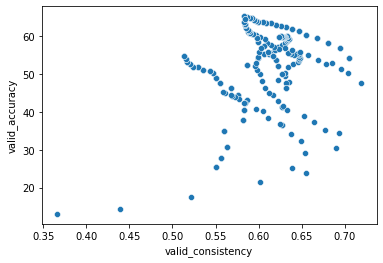

In [81]:
results_ = results.pivot_table(
  key,
  index = ['data_mode', 'batch_size'],
  columns = ['steps'],
  aggfunc = "max"
).stack()

sns.scatterplot(data = results[results.batch_size == 7200], x = 'valid_consistency', y = 'valid_accuracy')

In [93]:
results

,batch_size,conditional,delta,device,learning_rate,loss_distance,model,num_hidden_units,num_output,num_steps,...,valid_ratio,variant,steps,data_mode,repeat,valid_accuracy,test_accuracy,train_consistency,valid_consistency,test_consistency
0,7200,time_delta,0.1,cuda,0.0003,cosine,offset10-model,128,128,1000,...,0.1,single-session,50,multi-session,4.0,48.333333,48.333333,0.706605,0.622095,0.642730
1,7200,time_delta,0.1,cuda,0.0003,cosine,offset10-model,128,128,1000,...,0.1,single-session,50,single-session,4.0,52.255892,52.255892,0.577021,0.586396,0.604711
2,7200,time_delta,0.1,cuda,0.0003,cosine,offset10-model,128,128,1000,...,0.1,single-session,50,time-contrastive,4.0,52.255892,52.255892,0.577021,0.586396,0.604711
3,7200,time_delta,0.1,cuda,0.0003,cosine,offset10-model,128,128,1000,...,0.1,single-session,100,multi-session,4.0,47.850730,47.850730,0.808409,0.635128,0.659155
4,7200,time_delta,0.1,cuda,0.0003,cosine,offset10-model,128,128,1000,...,0.1,single-session,100,single-session,4.0,54.180696,54.180696,0.654319,0.599732,0.616261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,7200,time_delta,0.1,cuda,0.3000,cosine,offset10-model,128,128,1000,...,0.1,single-session,950,single-session,4.0,54.029181,54.029181,0.870786,0.515351,0.527374
236,7200,time_delta,0.1,cuda,0.3000,cosine,offset10-model,128,128,1000,...,0.1,single-session,950,time-contrastive,4.0,54.029181,54.029181,0.870786,0.515351,0.527374
237,7200,time_delta,0.1,cuda,0.3000,cosine,offset10-model,128,128,1000,...,0.1,single-session,1000,multi-session,4.0,45.129068,45.129068,0.997890,0.559045,0.584718
238,7200,time_delta,0.1,cuda,0.3000,cosine,offset10-model,128,128,1000,...,0.1,single-session,1000,single-session,4.0,54.691358,54.691358,0.876165,0.512891,0.525487


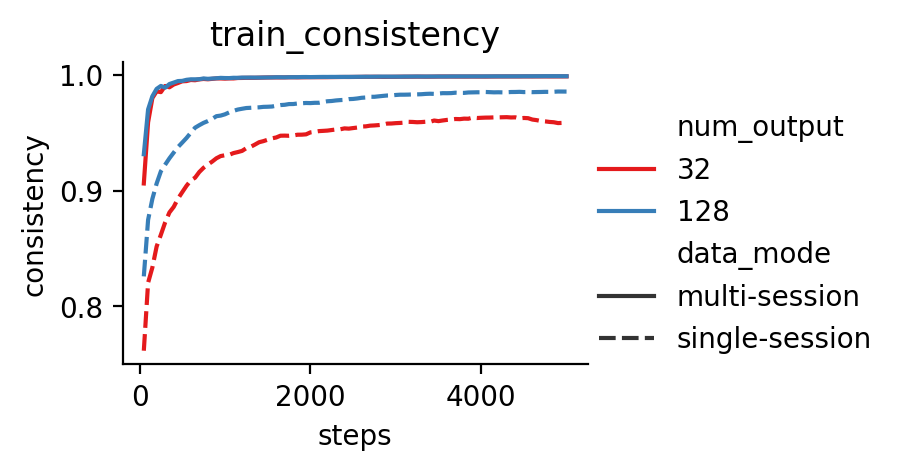

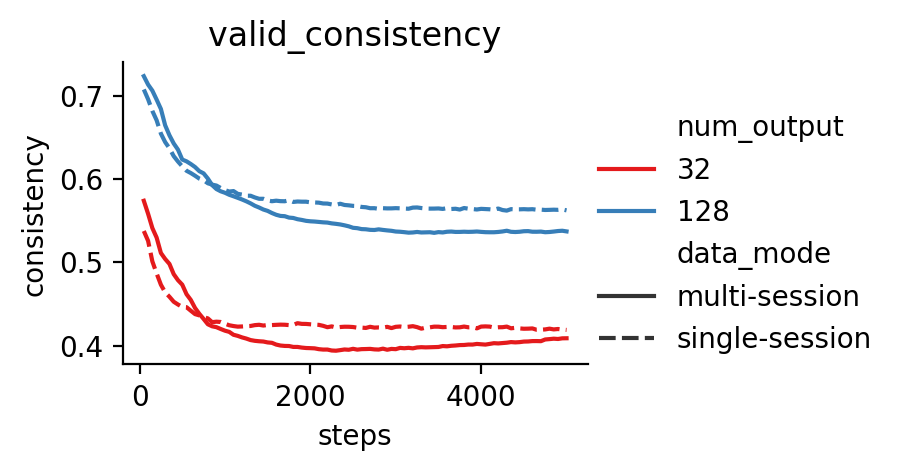

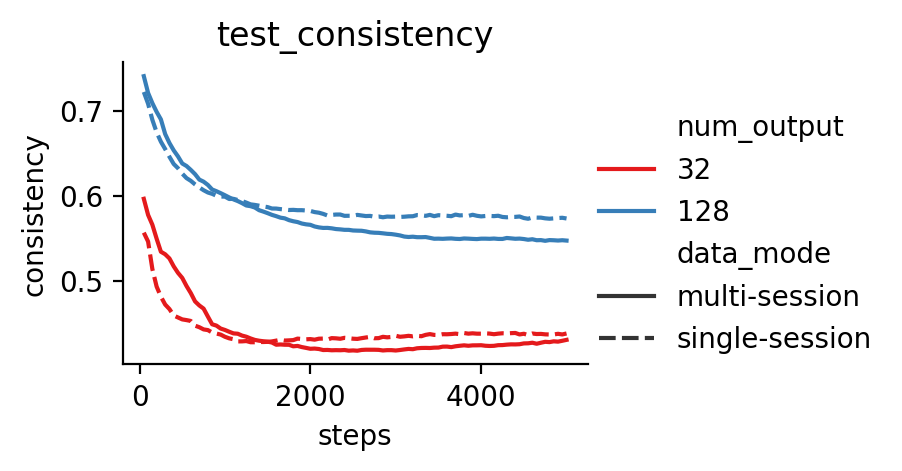

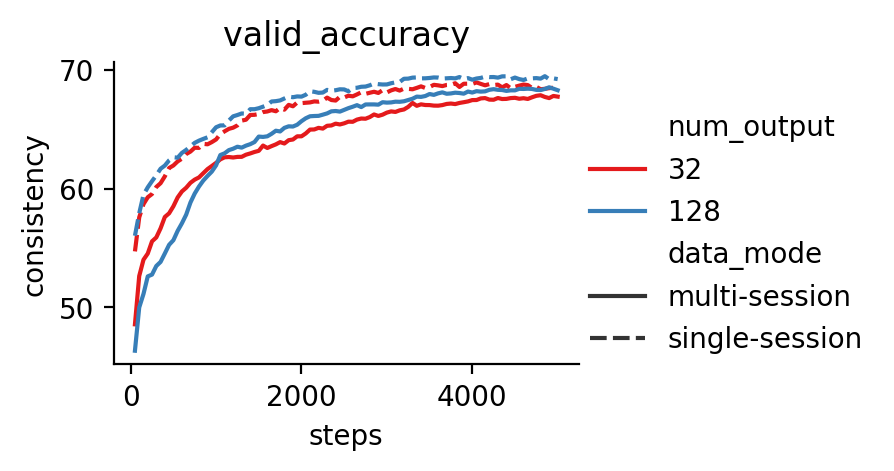

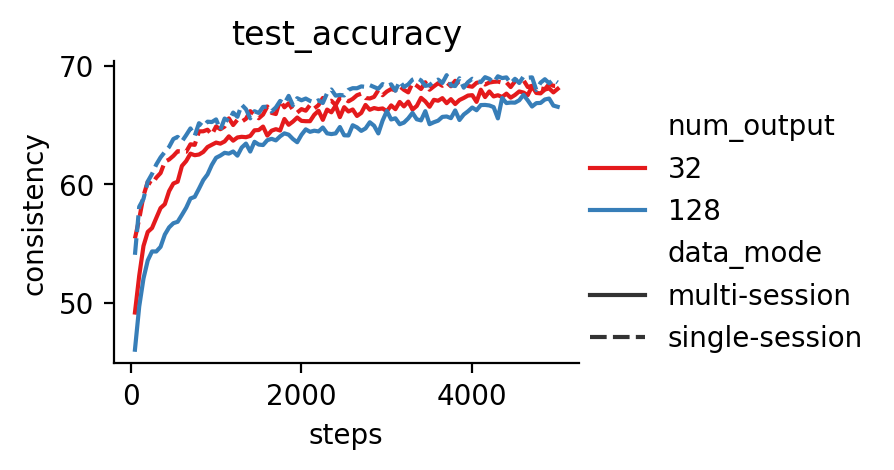

In [8]:
def plot(results, key):
  
  results = results.copy()
  results = results[results.data_mode != "time-contrastive"]
  
  figure()
  
  index = 'num_output'

  results = results.pivot_table(
    key,
    index = ['data_mode', index],
    columns = ['steps'],
    aggfunc = "max"
  ).stack()

  results.name = 'consistency'
  results = results.reset_index()

  sns.lineplot(
    data = results,
    x = 'steps',
    y = 'consistency',
    hue = index,
    style = 'data_mode',
    palette = 'Set1'
  )
  plt.legend(loc=(1,0),frameon = False)
  
  sns.despine(trim = False)
  plt.title(key)
  plt.show()
  
plot(results, "train_consistency")
plot(results, "valid_consistency")
plot(results, "test_consistency")

plot(results, "valid_accuracy")
plot(results, "test_accuracy")